Starting FOV calculation with the Final Robust Scanning algorithm (V12.1)...
[INFO] sfov table saved to: ./Monza_sfov_V12_final.csv

Calculation complete. Visualizing results...


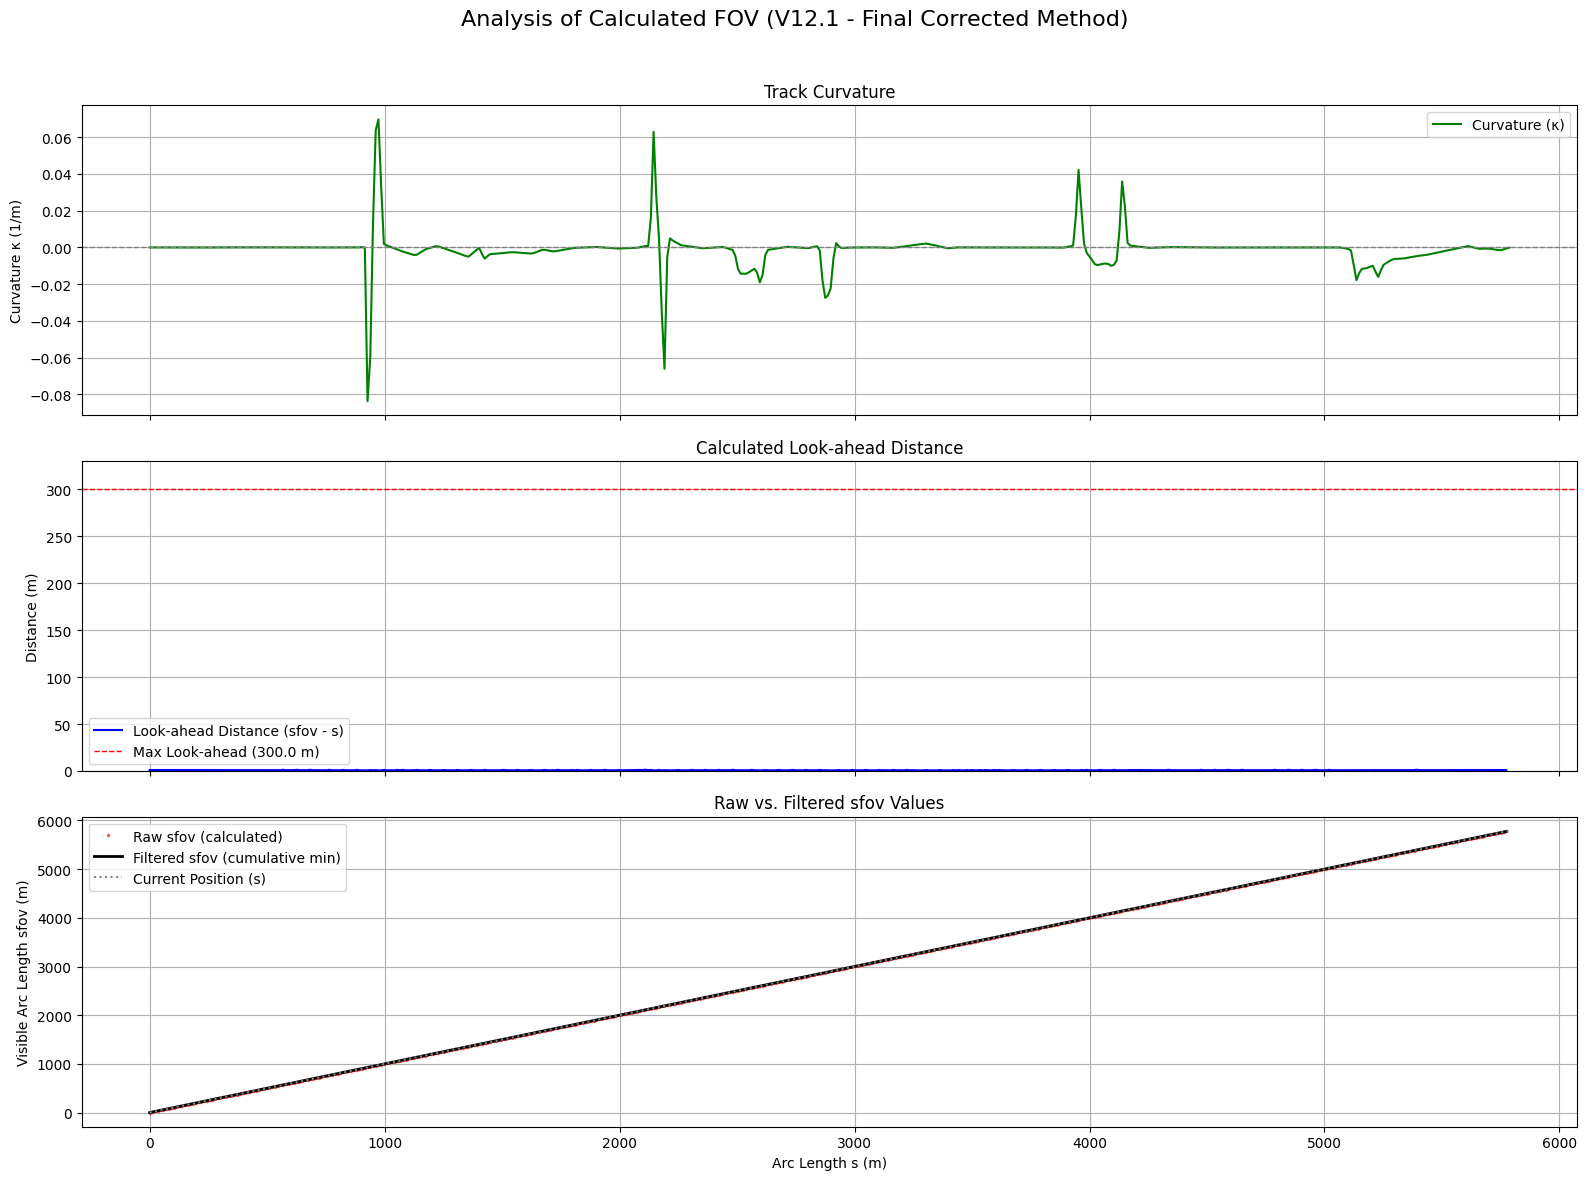

In [4]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
import os

# ======================================================================
# =================== PART 1: DATA LOADING AND SPLINE ==================
# ======================================================================

file_path = "Monza.csv"
try:
    df = pd.read_csv(file_path)
    if '# x_m' not in df.columns and 'x_m' in df.columns:
        df.rename(columns={'x_m': '# x_m'}, inplace=True)
except (FileNotFoundError, KeyError) as e:
    print(f"Error loading or parsing CSV file: {e}"); exit()

x, y = df['# x_m'].values, df['y_m'].values
w_left, w_right = df['w_tr_left_m'].values, df['w_tr_right_m'].values

s = np.zeros(len(x)); s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2)); s_max = s[-1]
x_spline, y_spline = CubicSpline(s, x), CubicSpline(s, y)
dx_ds, dy_ds = x_spline.derivative(1), y_spline.derivative(1)
d2x_ds2, d2y_ds2 = x_spline.derivative(2), y_spline.derivative(2)

# ======================================================================
# ======== PART 2: THE ROBUST FOV CALCULATION (V12.1 - FINAL) ========
# ======================================================================

DENSE_STEP, DELTA_S, SLIDING_WIN = 1.0, 300.0, 80.0

def build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig):
    xc, yc = spline_x(s_dense), spline_y(s_dense)
    dx, dy = spline_x.derivative(1)(s_dense), spline_y.derivative(1)(s_dense)
    norm_t = np.hypot(dx, dy)
    with np.errstate(divide='ignore', invalid='ignore'):
        nx, ny = -dy / norm_t, dx / norm_t
    nx[np.isnan(nx)], ny[np.isnan(ny)] = 0, 0
    w_left_d  = np.interp(s_dense, s_orig, w_left)
    w_right_d = np.interp(s_dense, s_orig, w_right)
    return (xc + nx * w_left_d, yc + ny * w_left_d), (xc - nx * w_right_d, yc - ny * w_right_d)

def first_crossing_final(s0: float, ray_origin: np.ndarray, ray_direction: np.ndarray,
                         line_x: np.ndarray, line_y: np.ndarray,
                         line_s_coords: np.ndarray) -> float:
    """Finds the first valid FORWARD intersection of a ray with a line strip."""
    min_s_intersect = np.inf
    for i in range(len(line_x) - 1):
        A, B = np.array([line_x[i], line_y[i]]), np.array([line_x[i+1], line_y[i+1]])
        v = B - A
        M_det = ray_direction[0] * (-v[1]) - ray_direction[1] * (-v[0])
        if abs(M_det) < 1e-9: continue
        rhs = A - ray_origin
        t = (rhs[0] * (-v[1]) - rhs[1] * (-v[0])) / M_det
        u = (ray_direction[0] * rhs[1] - ray_direction[1] * rhs[0]) / M_det
        if t > 1e-3 and 0.0 <= u <= 1.0:
            s_intersect = line_s_coords[i] + u * (line_s_coords[i+1] - line_s_coords[i])
            if s_intersect > s0 and s_intersect < min_s_intersect:
                min_s_intersect = s_intersect
    return min_s_intersect

def compute_fov_all_final(spline_x, spline_y,
                          w_left: np.ndarray, w_right: np.ndarray,
                          s_query: np.ndarray, s_orig: np.ndarray, s_max_val: float,
                          delta_s: float = DELTA_S,
                          step: float = DENSE_STEP):
    s_dense = np.arange(0, s_max_val + step, step)
    (xl, yl), (xr, yr) = build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig)
    sfov_raw = np.empty_like(s_query)
    ray_angles = np.deg2rad(np.arange(-80, 81, 5)) 

    for k, s0 in enumerate(s_query):
        s0_pos = np.array([spline_x(s0), spline_y(s0)])
        raw_dir_vec = np.array([dx_ds(s0), dy_ds(s0)])
        heading_vec = raw_dir_vec / np.linalg.norm(raw_dir_vec)
        
        idx0_s = np.searchsorted(s_dense, s0)
        idxw_s = np.searchsorted(s_dense, s0 + delta_s)
        s_win, xl_win, yl_win = s_dense[idx0_s:idxw_s], xl[idx0_s:idxw_s], yl[idx0_s:idxw_s]
        xr_win, yr_win = xr[idx0_s:idxw_s], yr[idx0_s:idxw_s]

        min_s_overall = np.inf
        
        for angle in ray_angles:
            c, s_rot = np.cos(angle), np.sin(angle)
            ray_dir = np.array([[c, -s_rot], [s_rot, c]]) @ heading_vec
            
            # --- CORRECTED CALLS TO first_crossing_final ---
            s_left = first_crossing_final(s0, s0_pos, ray_dir, xl_win, yl_win, s_win)
            s_right = first_crossing_final(s0, s0_pos, ray_dir, xr_win, yr_win, s_win)
            # -----------------------------------------------
            
            min_s_overall = min(min_s_overall, s_left, s_right)
        
        sfov_raw[k] = min_s_overall

    # --- THE CUMULATIVE MINIMUM FILTER ---
    sfov_filt = np.copy(sfov_raw)
    for i in range(len(sfov_filt) - 2, -1, -1):
        sfov_filt[i] = min(sfov_filt[i], sfov_filt[i+1])
    # -------------------------------------
    
    return sfov_raw, sfov_filt

def save_sfov_csv(s_samples, sfov_samples, in_csv_path, out_name="sfov_lookup.csv"):
    df_out = pd.DataFrame({"s_m": s_samples, "sfov_m": sfov_samples})
    out_dir = os.path.dirname(os.path.abspath(in_csv_path)) if os.path.dirname(in_csv_path) else '.'
    full_path = os.path.join(out_dir, out_name)
    df_out.to_csv(full_path, index=False)
    print(f"[INFO] sfov table saved to: {full_path}")

# ======================================================================
# ================= PART 3: EXECUTION AND VISUALIZATION =================
# ======================================================================

s_query = np.linspace(0, s_max, 500)
print("Starting FOV calculation with the Final Robust Scanning algorithm (V12.1)...")

sfov_raw_vals, sfov_filtered_vals = compute_fov_all_final(
    x_spline, y_spline, w_left, w_right, s_query, s, s_max
)

save_sfov_csv(s_query, sfov_filtered_vals, file_path, "Monza_sfov_V12_final.csv")
print("\nCalculation complete. Visualizing results...")

look_ahead_dist = sfov_filtered_vals - s_query
kappa_query = (dx_ds(s_query) * d2y_ds2(s_query) - dy_ds(s_query) * d2x_ds2(s_query))

fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Analysis of Calculated FOV (V12.1 - Final Corrected Method)', fontsize=16)
axs[0].plot(s_query, kappa_query, color='green', label='Curvature (κ)')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1); axs[0].set_ylabel("Curvature κ (1/m)"); axs[0].set_title("Track Curvature"); axs[0].legend(); axs[0].grid(True)
axs[1].plot(s_query, look_ahead_dist, color='blue', label='Look-ahead Distance (sfov - s)')
axs[1].axhline(DELTA_S, color='red', linestyle='--', linewidth=1, label=f'Max Look-ahead ({DELTA_S} m)'); axs[1].set_ylabel("Distance (m)"); axs[1].set_title("Calculated Look-ahead Distance"); axs[1].legend(); axs[1].grid(True); axs[1].set_ylim(0, DELTA_S * 1.1)
axs[2].plot(s_query, sfov_raw_vals, 'r.', markersize=3, alpha=0.6, label='Raw sfov (calculated)')
axs[2].plot(s_query, sfov_filtered_vals, 'k-', linewidth=2, label='Filtered sfov (cumulative min)')
axs[2].plot(s_query, s_query, ':', color='gray', linewidth=1.5, label='Current Position (s)'); axs[2].set_xlabel("Arc Length s (m)"); axs[2].set_ylabel("Visible Arc Length sfov (m)"); axs[2].set_title("Raw vs. Filtered sfov Values"); axs[2].legend(); axs[2].grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()